# Project Goal

The goal of this project is to build an accurate image classification model using a small, custom dataset of images that we collected ourselves. 

Training a deep neural network from scratch usually requires a large amount of data and computational resources. To overcome this, we use **transfer learning** - a method where we start with a pre-trained model (trained on millions of images) and fine-tune it to our specific dataset.

This approach uses existing learned features, allowing us to achieve good accuracy more quickly and efficiently, even with limited data.
ata.
```


## Dataset Splitting 

Let's organize our dataset into training, validation, and test sets for a rock-paper-scissors classification task.

- **Source Directory:** Contains the original images sorted by class (`rock`, `paper`, `scissor`).
- **Target Directory:** Where the split datasets (`train`, `validation`, `test`) will be saved in separate folders for each class.
- **Split Ratios:** 70% training, 15% validation, 15% test.
- **Process:**
  - Create folders for each split and class.
  - Shuffle images to ensure randomness.
  - Copy images into corresponding folders based on split ratios.

In [3]:
import os
import random
import shutil
from pathlib import Path

# Paths
SOURCE_DIR = 'test/rps'
TARGET_DIR = 'dataset_split'
SPLITS = {'train': 0.7, 'validation': 0.15, 'test': 0.15}
CLASSES = ['rock', 'paper', 'scissor']

# Ensure repeatability
random.seed(123)

# Create split directories
for split in SPLITS:
    for cls in CLASSES:
        Path(os.path.join(TARGET_DIR, split, cls)).mkdir(parents=True, exist_ok=True)

# Split data
for cls in CLASSES:
    source_path = os.path.join(SOURCE_DIR, cls)
    images = os.listdir(source_path)
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * SPLITS['train'])
    n_val = int(n_total * SPLITS['validation'])

    split_data = {
        'train': images[:n_train],
        'validation': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }

    for split, files in split_data.items():
        for f in files:
            src = os.path.join(source_path, f)
            dst = os.path.join(TARGET_DIR, split, cls, f)
            shutil.copy2(src, dst)

print("✅ Dataset successfully split and copied!")


✅ Dataset successfully split and copied!


## Loading Image Datasets with TensorFlow
We rely on s TensorFlow’s `image_dataset_from_directory` utility to load images from the previously split dataset directories.

- **Purpose:** Efficiently create batches of images and labels directly from folder structures.
- **Parameters:**
  - `image_size=(128, 128)`: Resizes all images to 128x128 pixels.
  - `batch_size=32`: Groups images into batches of 32 for training efficiency.
- **Datasets:**
  - `train_dataset`: Contains training images and labels.
  - `val_dataset`: Contains validation images for tuning model parameters.
  - `test_dataset`: Contains test images for final nd testing.


In [5]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory('dataset_split/train', image_size=(128, 128), batch_size=32)
val_dataset = image_dataset_from_directory('dataset_split/validation', image_size=(128, 128), batch_size=32)
test_dataset = image_dataset_from_directory('dataset_split/test', image_size=(128, 128), batch_size=32)

Found 313 files belonging to 3 classes.
Found 113 files belonging to 3 classes.
Found 94 files belonging to 3 classes.


## Visualizing Data Augmentation Examples

Let's visualize how data augmentation transforms an original image into multiple augmented versions.

- **Step 1:** Extract one image from the training dataset.
- **Step 2:** Plot the original image.
- **Step 3:** Generate and plot 8 different augmented images using the `data_augmentation` pipeline, which applies random flips, rotations, zooms, and contrast changes.
- **Step 4:** Display all images in a 3x3 grid with titles and without axes for clarity.

This helps to understand the diversity introduced by data augmentation, improving model generalization.


In [7]:
from tensorflow.keras import layers, models

# Data Augmentation block
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")

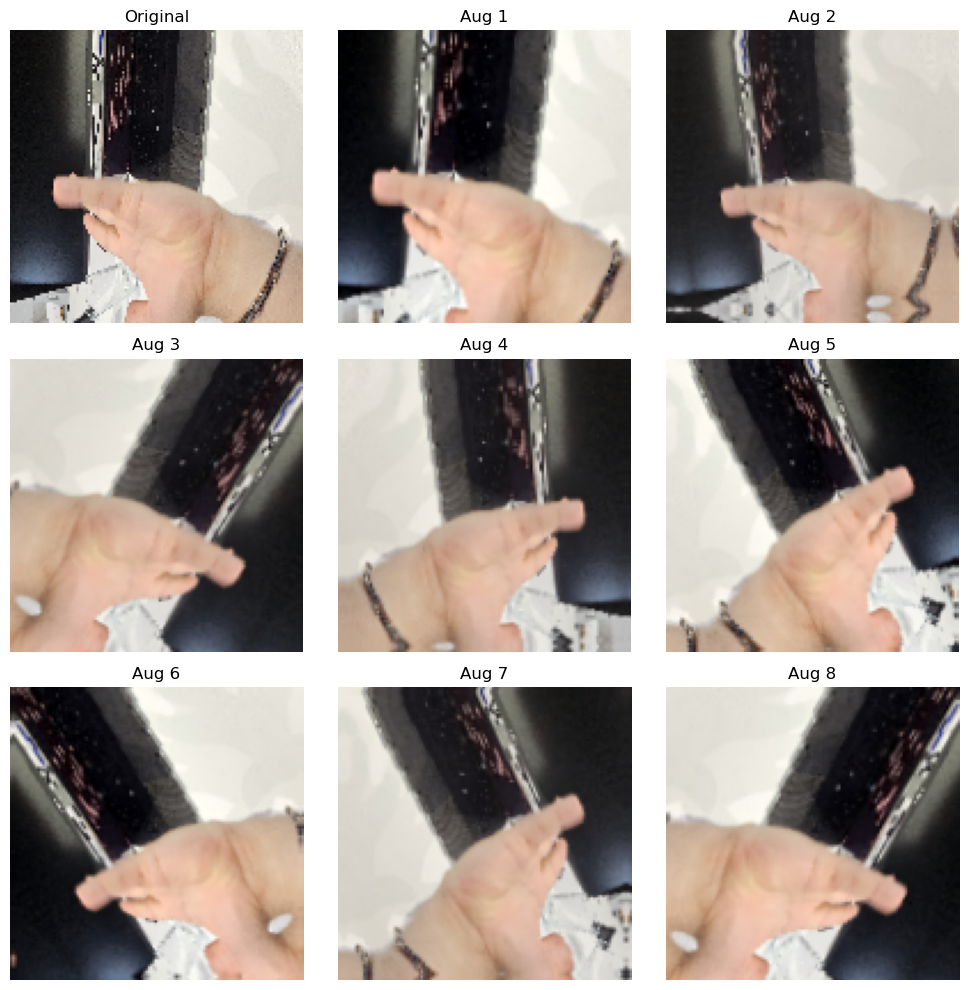

In [8]:
import matplotlib.pyplot as plt

# Get one image from the dataset
for images, labels in train_dataset.take(1):
    original_image = images[0]  # Pick the first image in the batch
    break  # Exit the loop

# Plot the original and 8 augmentations
plt.figure(figsize=(10, 10))

# Show original
plt.subplot(3, 3, 1)
plt.imshow(original_image.numpy().astype("uint8"))
plt.title("Original")
plt.axis("off")

# Show 8 augmented versions
for i in range(8):
    augmented_image = data_augmentation(tf.expand_dims(original_image, 0))[0]
    plt.subplot(3, 3, i + 2)
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.title(f"Aug {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()


## Model Definition Using Transfer Learning with MobileNetV2
Next, we define s a deep learning model using TensorFlow Keras, leveraging transfer learning for image classification.

- **Input Shape:** Images resized to 128x128 with 3 color channels (RGB).
- **Number of Classes:** 3 (rock, paper, scissor).

### Components:

- **Data Augmentation:** 
  - Random horizontal flip, rotation, zoom, and contrast adjustment.
  - Helps improve model robustness by artificially expanding training data.

- **Base Model:** 
  - MobileNetV2 pretrained on ImageNet.
  - Top classification layers removed (`include_top=False`).
  - Weights are frozen initially (`base_model.trainable = False`) to preserve learned features.

- **Model Architecture:**
  - Inputs pass through data augmentation.
  - Images preprocessed specifically for MobileNetV2.
  - Features extracted by the frozen base model.
  - Global average pooling converts feature maps into a vector.
  - Dropout layers added to reduce overfitting.
  - Dense layers learn task-specific features.
  - Final output layer with softmax activation predicts class probabilities.

- **Compilation:**
  - Optimizer: Adam (default learning rate).
  - Loss: Sparse categorical cross-entropy (for integer labels).
  - Metric: Accuracy tohe model layers and parameters.


In [10]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

input_shape = (128, 128, 3)
num_classes = 3



# Load MobileNetV2 backbone, exclude top layers, weights from ImageNet
base_model = MobileNetV2(input_shape=input_shape,
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build model
inputs = layers.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)  # preprocess for MobileNetV2
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training the Model with Early Stopping

This code trains the model using an early stopping strategy to prevent overfitting and save training time.

- **EarlyStopping Callback:**
  - Monitors the validation loss (`val_loss`).
  - Stops training if `val_loss` does not improve for 5 consecutive epochs (`patience=5`).
  - Restores the best model weights recorded during training.

- **Model Compilation:**
  - Uses the Adam optimizer.
  - Uses sparse categorical crossentropy loss (suitable for integer class labels).
  - Tracks accuracy as a metric.

- **Model Training:**
  - Trains on the `train_dataset`.
  - Validates on the `val_dataset`.
  - Runs for up to 32 epochs, but may stop earlier due to early stopping.

This approach helps ensure the model trains efficiently and generalizes well on unseen data.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,        # Stop if val_loss doesn't improve after 3 epochs
    restore_best_weights=True
)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=32,
    callbacks=[early_stop]
)



Epoch 1/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.3633 - loss: 1.6115 - val_accuracy: 0.6903 - val_loss: 0.8351
Epoch 2/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5932 - loss: 0.9035 - val_accuracy: 0.5310 - val_loss: 0.9094
Epoch 3/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6832 - loss: 0.7589 - val_accuracy: 0.7965 - val_loss: 0.5650
Epoch 4/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7198 - loss: 0.6628 - val_accuracy: 0.7699 - val_loss: 0.5690
Epoch 5/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.7539 - loss: 0.4959 - val_accuracy: 0.8407 - val_loss: 0.4222
Epoch 6/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7951 - loss: 0.5357 - val_accuracy: 0.8496 - val_loss: 0.4435
Epoch 7/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7670 - loss: 0.4637 - val_accuracy: 0.7876 - val_loss: 0.5503
Epoch 8/32
10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8628 - loss: 0.3635 - val_accuracy: 0.8673 - val_loss:

## Training History Visualization

- Plots training and validation accuracy.
- Plots training and validation loss.
- Helps monitor model performance and overfitting.


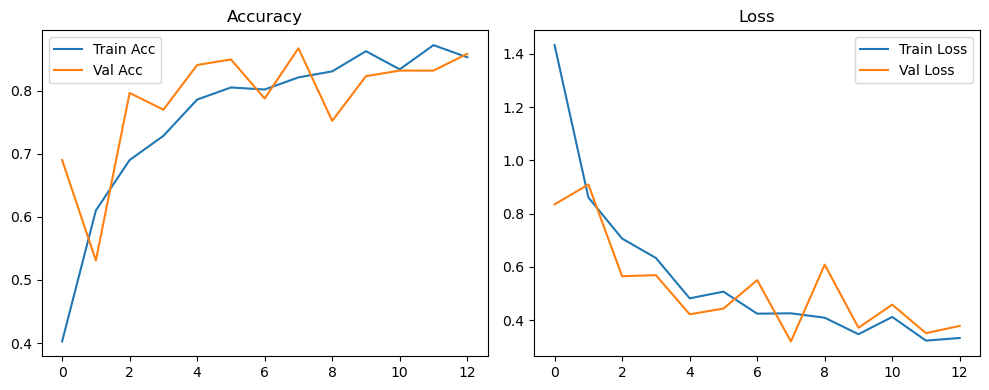

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## Evaluate Model and Visualize Predictions

- Evaluate the model on the test dataset and print test loss and accuracy.
- Use the model to predict classes on one batch of test images.
- Display the first 8 test images with their true labels and predicted labels side by side.
- Helps check how well the model performs visually on unseen data.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.8435 - loss: 0.3832
Test Loss: 0.3797
Test Accuracy: 0.8511
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


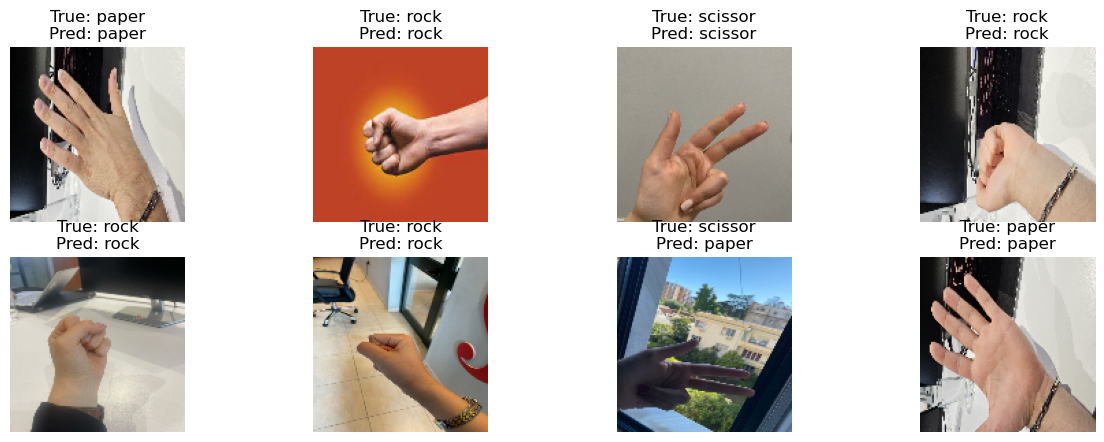

In [16]:
# Evaluate on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Optional: Get predictions and visualize some test images with predictions
import numpy as np

class_names = test_dataset.class_names  # assuming your dataset has this attribute

for images, labels in test_dataset.take(1):  # take one batch from test set
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):  # show first 8 images in batch
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds_classes[i]]}")
        plt.axis("off")
    plt.show()


## Confusion Matrix for Test Set

- Collect true and predicted labels from the entire test dataset.
- Compute the confusion matrix to summarize prediction performance per class.
- Visualize the confusion matrix as a heatmap with annotations.
- Helps identify which classes are confused and overall model accuracy per class.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


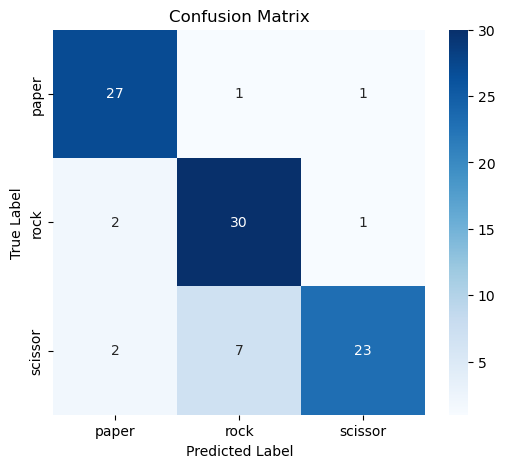

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels for the entire test set
true_labels = []
pred_labels = []

class_names = test_dataset.class_names

for images, labels in test_dataset:
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    true_labels.extend(labels.numpy())
    pred_labels.extend(preds_classes)

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Fine-tuning the Model in Detail

- **Unfreeze specific layers:**  
  We set `base_model.trainable = True` to allow training on the whole base model, then freeze the first 100 layers by setting their `trainable` attribute to `False`.  
  This means only the layers from 101 onward will update their weights during training. This approach helps retain learned features in early layers while fine-tuning deeper layers for our specific task.

- **Recompile with a lower learning rate:**  
  We use the Adam optimizer with a small learning rate (`1e-5`).  
  A lower learning rate prevents large weight updates that could "unlearn" the useful pretrained features during fine-tuning.

- **Train the model:**  
  The model is trained for 15 epochs using the training dataset (`train_dataset`) and validated on the validation dataset (`val_dataset`).  
  This further adapts the model to our specific image dataset, improving performance without overfitting or losing the pretrained knowledge.


In [20]:
# Unfreeze from a specific layer 
base_model.trainable = True
for layer in base_model.layers[:85]:
    layer.trainable = False

# Recompile with a lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train again
fine_tune_history = model.fit(train_dataset, validation_data=val_dataset, epochs=15)


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6434 - loss: 1.0242 - val_accuracy: 0.8673 - val_loss: 0.3117
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6957 - loss: 0.8094 - val_accuracy: 0.8761 - val_loss: 0.3035
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6729 - loss: 0.8138 - val_accuracy: 0.8761 - val_loss: 0.2930
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7498 - loss: 0.6337 - val_accuracy: 0.8850 - val_loss: 0.2818
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.6812 - loss: 0.7008 - val_accuracy: 0.9027 - val_loss: 0.2716
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7331 - loss: 0.6508 - val_accuracy: 0.9027 - val_loss: 0.2653
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.7333 - loss: 0.6804 - val_accuracy: 0.9027 - val_loss: 0.2593
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7099 - loss: 0.6655 - val_accuracy: 0.9027 - val_loss:

## Evaluate Model on Test Data

- Use `model.evaluate()` on `test_dataset` to measure final performance.
- This returns the loss and accuracy on unseen test images.
- Print the test loss and accuracy with 4 decimal places for clarity.

In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.8854 - loss: 0.2848
Test Loss: 0.2959
Test Accuracy: 0.8723


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


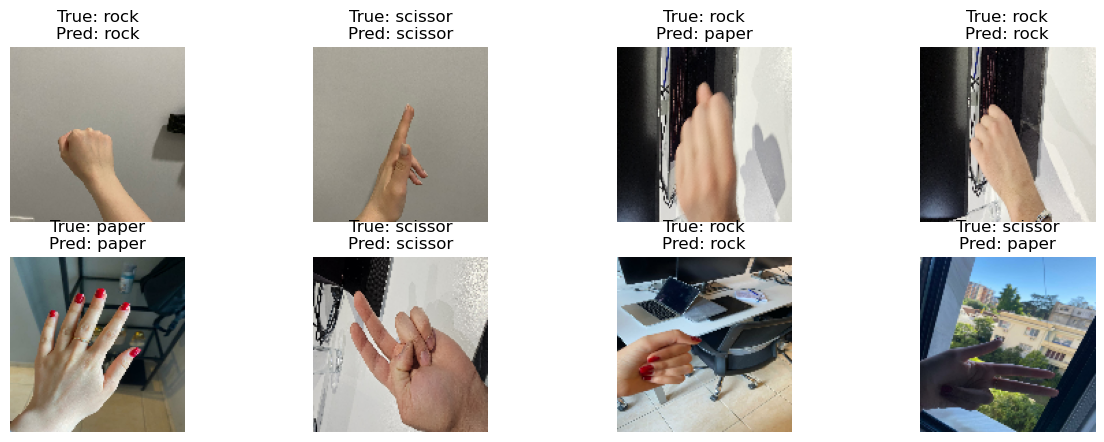

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class_names = test_dataset.class_names  # If test_dataset was made with image_dataset_from_directory

for images, labels in test_dataset.take(1):  # Take one batch
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=1)
    
    plt.figure(figsize=(15, 5))
    for i in range(8):  # Show first 8 images
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[preds_classes[i]]}")
        plt.axis("off")
    plt.show()

## Conclusion
After fine-tuning, the model was evaluated on the test dataset to measure its real-world performance. The resulting test loss and accuracy indicate how well the model generalizes to unseen data. A high accuracy and low loss mean the model learned useful features and can reliably classify new images..
